# Used Cars pricing using XGBoostRegressor (Kaggle dataset)

TODO:
- transform and scale new data for prediction after the model has been saved
- isolate new data predictions from the model building code

In [15]:
# Display plots inline
%matplotlib inline

# upgrade scikit-learn and xgboost to the latest
!pip install --upgrade scikit-learn
!pip install xgboost==1.7.6  # Replace with a compatible version.

# Import core libraries
import pandas as pd
import numpy as np
#matplotlib.use('Agg')  # Use 'Agg' backend for non-GUI environments
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

import joblib  # Use joblib to save and load the model
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('used_cars.csv')

# This record added so it can be transformed with the rest of the
# data set, then removed before training. It was used for prediction
# after the model was trained.
new_data = pd.DataFrame({
    'brand': ['Toyota'],
    'model': ['Tacoma'],
    'model_year': [2019],
    'milage': [86000],
    'fuel_type': ['Gasoline'],
    'engine': ['275HP'],
    'transmission': ['Automatic'],
    'ext_col': ['Blue'],
    'int_col': ['Gray'],
    'accident': ['None reported'],
    'clean_title': ['Yes'],
    'price': [40000]
})
# Append the Tacoma data to the original data
data = pd.concat([data, new_data], ignore_index=True)

print("Last 5 records of the dataset:")
print(data.tail())



Last 5 records of the dataset:
        brand                 model  model_year      milage fuel_type  \
4005     Audi  S4 3.0T Premium Plus        2022  10,900 mi.  Gasoline   
4006  Porsche                Taycan        2022   2,116 mi.       NaN   
4007     Ford          F-150 Raptor        2020  33,000 mi.  Gasoline   
4008      BMW          X3 xDrive30i        2020  43,000 mi.  Gasoline   
4009   Toyota                Tacoma        2019       86000  Gasoline   

                                             engine  \
4005  349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
4006                                       Electric   
4007  450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel   
4008   248.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
4009                                          275HP   

                        transmission ext_col int_col  \
4005  Transmission w/Dual Shift Mode   Black   Black   
4006                       Automatic   Black   Black   
4007                           

### Get basic dataset info

In [16]:
# Get basic info
print(data.info())

print("\nMissing values in each column:")
print(data.isnull().sum())

# Check for duplicates
#print(data.duplicated().sum())

print("\nStatistical summary of numerical features:")
print(data.describe())

# find unique fuel_types
print("\nUnique fuel types:")
print(data['fuel_type'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010 entries, 0 to 4009
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4010 non-null   object
 1   model         4010 non-null   object
 2   model_year    4010 non-null   int64 
 3   milage        4010 non-null   object
 4   fuel_type     3840 non-null   object
 5   engine        4010 non-null   object
 6   transmission  4010 non-null   object
 7   ext_col       4010 non-null   object
 8   int_col       4010 non-null   object
 9   accident      3897 non-null   object
 10  clean_title   3414 non-null   object
 11  price         4010 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.1+ KB
None

Missing values in each column:
brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title    

### Data Cleaning and Preprocessing


Statistical summary of numerical features:
              milage         price          age    engine_hp
count    4010.000000  4.010000e+03  4010.000000  4010.000000
mean    64714.572818  4.454981e+04     8.483541   305.553117
std     52290.416747  7.870111e+04     6.104303   121.424238
min       100.000000  2.000000e+03     0.000000    70.000000
25%     23053.750000  1.720000e+04     4.000000   200.000000
50%     52775.000000  3.100000e+04     7.000000   285.000000
75%     94100.000000  4.998000e+04    12.000000   381.000000
max    405000.000000  2.954083e+06    50.000000  1020.000000
Value counts:

brand
Ford             386
BMW              375
Mercedes-Benz    315
Chevrolet        292
Porsche          201
Audi             200
Toyota           200
Lexus            163
Jeep             143
Land             130
Nissan           116
Cadillac         107
GMC               91
RAM               91
Dodge             90
Tesla             87
Kia               76
Hyundai           72
Mazda   

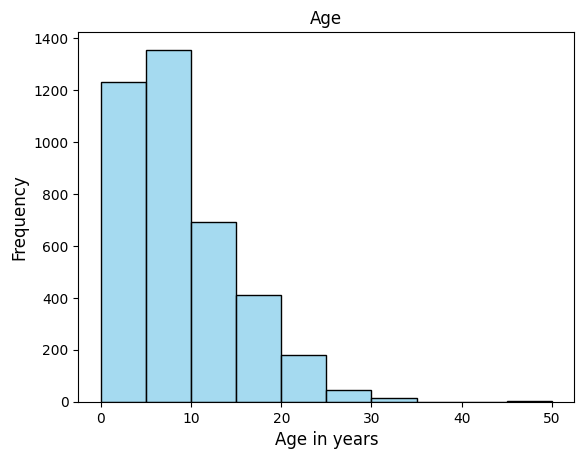

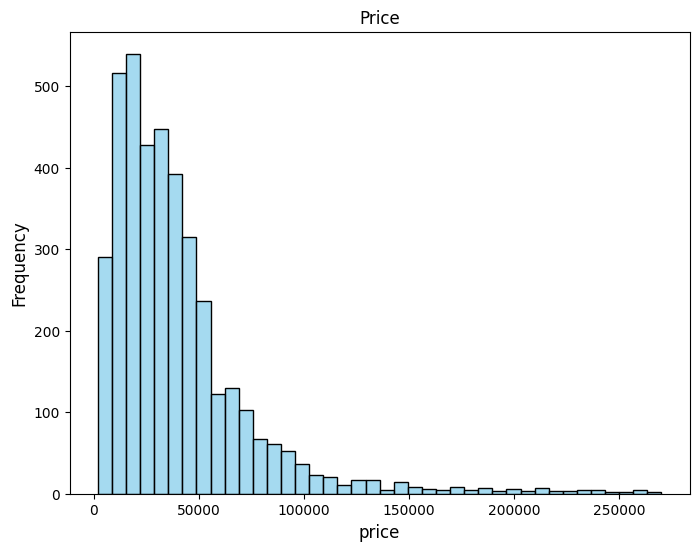

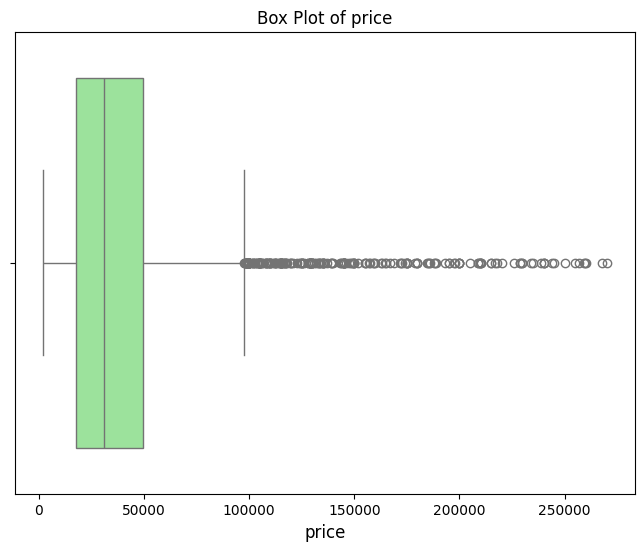

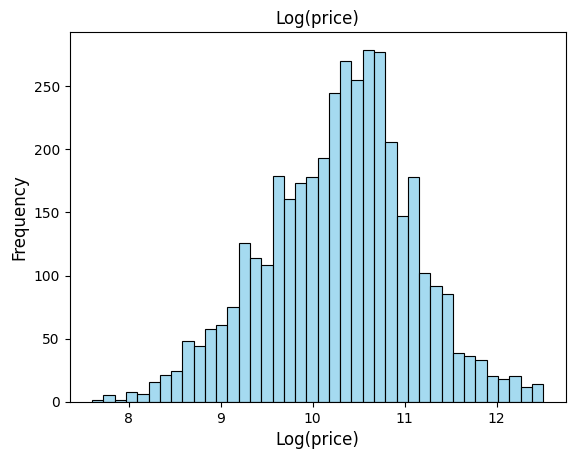

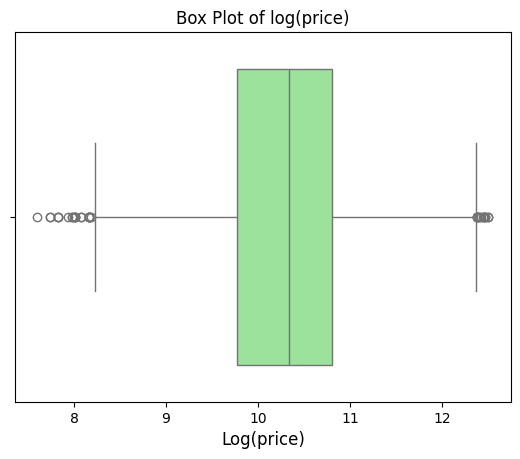


Data after encoding categorical variables and feature engineering:
    milage      price  age  engine_hp  brand_Alfa  brand_Aston  brand_Audi  \
0  51000.0   9.239996   11      300.0       False        False       False   
1  34742.0  10.545499    3      200.0       False        False       False   
2  22372.0  10.907771    2      200.0       False        False       False   
3  88900.0   9.648660    9      354.0       False        False       False   
4   9835.0  10.463103    3      200.0       False        False        True   

   brand_BMW  brand_Bentley  brand_Buick  ...  model_xB Base  \
0      False          False        False  ...          False   
1      False          False        False  ...          False   
2      False          False        False  ...          False   
3      False          False        False  ...          False   
4      False          False        False  ...          False   

   fuel_type_E85 Flex Fuel  fuel_type_Electric  fuel_type_Gasoline  \
0       

In [17]:
# Data cleaning and Preprocessing

def clean_milage(df):
    # Clean the milage field
    df['milage'] = df['milage'].str.replace('"', '')      # Remove double quotes
    df['milage'] = df['milage'].str.replace(' mi.', '')   # Remove ' mi.' from the end
    df['milage'] = df['milage'].str.replace(',', '')      # Remove commas
    # Convert to numeric
    df['milage'] = pd.to_numeric(df['milage'], errors='coerce')
    # Replace any missing values with the median
    df['milage'] = df['milage'].fillna(df['milage'].median())
    return df

data = clean_milage(data)

# Check for missing values in milage
#missing_milage = data['milage'].isnull().sum()
#print()
#print(f"Number of missing milage values: {missing_milage}")

def clean_price(df):
    # Clean the price field
    df['price'] = df['price'].str.replace('"', '')  # Remove double quotes
    df['price'] = df['price'].str.replace('$', '')  # Remove dollar signs
    df['price'] = df['price'].str.replace(',', '')  # Remove commas
    # Convert to numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    # Replace any missing values with the median
    df['price'] = df['price'].fillna(df['price'].median())
    return df

data = clean_price(data)

# Check for missing values in price
#missing_price = data['price'].isnull().sum()
#print()
#print(f"Number of missing price values: {missing_price}")

def create_age(df):
    # Create 'Age' feature
    # This is a more useful representation than using the model year
    current_year = 2024
    df['age'] = current_year - df['model_year']
    # drop the original model_year column
    df = data.drop('model_year', axis=1)
    return df

data = create_age(data)

# Handle missing values: fuel_type, accident, and clean_title

def clean_fuel_type(df):
    # Clean fuel_type
    # Replace 'not supported' with 'Hydrogen' (after inspection)
    df['fuel_type'] = df['fuel_type'].str.replace('not supported', 'Hydrogen')
    # Replace missing with 'Electric' (after inspection)
    df['fuel_type'] = df['fuel_type'].fillna('Electric')
    # Replace anything else with 'Gasoline'
    df['fuel_type'] = df['fuel_type'].str.replace(r'^[^a-zA-Z]', 'Gasoline', regex=True)
    return df

data = clean_fuel_type(data)

def clean_accident(df):
    # Clean accident
    # Replace missing with 'None reported'
    df['accident'] = df['accident'].fillna('None reported')
    return df

data = clean_accident(data)

def clean_engine(df):
    # Clean engine
    # Extract horsepower value as a string
    # note: many don't have HP, but do have engine size that could
    # be extracted as a new feature
    df['engine_hp_str'] = df['engine'].str.extract(r'(\d+\.?\d*)HP')
    # Convert the extracted horsepower strings to float
    df['engine_hp'] = pd.to_numeric(df['engine_hp_str'], errors='coerce')

    #print("\nMissing engine_hp values:")
    #print(data[data['engine_hp'].isnull()])

    return df

data = clean_engine(data)

# Drop the intermediate string column and the original engine feature
data = data.drop(columns=['engine', 'engine_hp_str'])
# Replace missing values with the median sedan HP (web search)
data['engine_hp'] = data['engine_hp'].fillna(200)

# Check for missing values in engine_hp
#missing_hp = data['engine_hp'].isnull().sum()
#print()
#print(f"Number of missing horsepower values: {missing_hp}")

def clean_transmission(df):
    # Clean Transmission
    # Initialize the 'transmission_clean' column with 'Automatic'
    df['transmission_clean'] = 'Automatic'
    # Assign 'Automatic' where condition 1 is met
    df.loc[df['transmission'].str.contains(r'A/T|Automatic', case=False, na=False), 'transmission_clean'] = 'Automatic'
    # Assign 'Manual' where condition 2 is met
    df.loc[df['transmission'].str.contains(r'M/T|Manual', case=False, na=False), 'transmission_clean'] = 'Manual'
    # Drop the original transmission feature
    df = df.drop(columns=['transmission'])
    return df

data = clean_transmission(data)

def clean_title(df):
    # Clean title
    # Replace missing with 'No'
    df['clean_title'] = df['clean_title'].fillna('No')
    return df

data = clean_title(data)

# Check for missing values in transmission_clean
#missing_transmission = data['transmission_clean'].isnull().sum()
#print()
#print(f"Number of missing transmission values: {missing_transmission}")

print()
print("Statistical summary of numerical features:")
print(data.describe())

print("Value counts:")
print()
print(data['brand'].value_counts())
print()
print(data['fuel_type'].value_counts())
print()
print(data['accident'].value_counts())
print()
print(data['clean_title'].value_counts())

# IQR FOR PRICE DID NOT IMPROVE THE MODEL SO COMMENTING OUT
# Scale the prices using IQR
# Calculate Q1, Q3, and IQR
#Q1 = data['price'].quantile(0.25)
#Q3 = data['price'].quantile(0.75)
#IQR = Q3 - Q1
# Normalize using the IQR method
#data['price'] = (data['price'] - Q1) / IQR

#print()
#print("Prices normalized with IQR")
#print(data['price'].head(10))

# Remove outliers from 'price' and 'milage'
# The model improved on mean absolute error and R-squared compared to
# leaving outliers in the dataset.
data = data[(data['price'] < data['price'].quantile(0.99)) &
            (data['milage'] < data['milage'].quantile(0.99))]

# Since interior color and exterior color had the lowest effect on price,
# drop them to simplify the model. This showed a very slight improvement
# in metrics.
data = data.drop(columns=['int_col', 'ext_col'])


# Visualizations

# Create a histogram of Age
sns.histplot(data['age'], bins=10, color='skyblue', edgecolor='black')
# Add titles and labels
plt.title('Age')
plt.xlabel('Age in years', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


# Histogram of price
plt.figure(figsize=(8, 6))
sns.histplot(data['price'], bins=40, color='skyblue', edgecolor='black')
plt.title('Price')
plt.xlabel('price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Configure x-axis to avoid scientific notation
#ax = plt.gca()
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# Ensure the style is plain (non-scientific)
#ax.ticklabel_format(style='plain', axis='x')

# Boxplot of price
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['price'], color='lightgreen')
plt.title('Box Plot of price', fontsize=12)
plt.xlabel('price', fontsize=12)
plt.show()


def log_price(df):
    # Apply log transformation to 'price' to handle skewness
    df['price'] = np.log1p(df['price'])  # log(1 + price)
    return df

data = log_price(data)

# Print first 10 prices after transform
#print("\n")
#print(data['price'].head(10))

# Create a histogram of log(price)
sns.histplot(data['price'], bins=40, color='skyblue', edgecolor='black')
plt.title('Log(price)')
plt.xlabel('Log(price)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Configure x-axis to avoid scientific notation
#ax = plt.gca()
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# Ensure the style is plain (non-scientific)
#ax.ticklabel_format(style='plain', axis='x')

# Boxplot of log(price)
sns.boxplot(x=data['price'], color='lightgreen')
plt.title('Box Plot of log(price)', fontsize=12)
plt.xlabel('Log(price)', fontsize=12)
plt.show()

def one_hot_categeoricals(df):
    # Handle categorical variables with One-Hot Encoding
    #categorical_cols = ['brand', 'model', 'fuel_type', 'transmission_clean', 'ext_col', 'int_col', 'accident', 'clean_title']
    categorical_cols = ['brand', 'model', 'fuel_type', 'transmission_clean', 'accident', 'clean_title']
    df = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
    return df

data = one_hot_categeoricals(data)

print("\nData after encoding categorical variables and feature engineering:")
print(data.head())



### Feature scaling and initial correlation analysis


In [13]:
# Feature Selection (target is price)
X = data.drop(['price'], axis=1)
y = data['price']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the fitted scaler for later use
# joblib.dump(scaler, 'scaler.pkl')

# Strip the last row (Tacoma) after scaling for later prediction
tacoma_data_scaled = X_scaled[-1].reshape(1, -1)
# Now, drop it so it is not included in training or testing
X_scaled = X_scaled[:-1]
# Also need to drop the price for the Tacoma so the number of rows matches
y = y[:-1]

# Linear Correlation Analysis
data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
data_scaled_price = data_scaled
data_scaled_price['Price'] = y

corr_matrix = data_scaled_price.corr()
print("\nCorrelation of features with Price:")
print(corr_matrix['Price'].sort_values(ascending=False))



Correlation of features with Price:
Price                         1.000000
model_e-tron Prestige         0.055394
model_Titan XD SV             0.054797
model_Avalanche 1500 LTZ      0.049576
model_CX-9 Touring Plus       0.043990
                                ...   
model_Tahoe RST                    NaN
model_V60 Cross Country T5         NaN
model_X3 M AWD                     NaN
model_XF 3.0 Portfolio             NaN
model_XJ8 Base                     NaN
Name: Price, Length: 1931, dtype: float64


### Build a machine learning model and make predictions

In [14]:
%%time

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Note: I started with a Random Forest Regressor, but found that XGBRegressor
# producted a better model. Finally, I added a grid search to improve
# the XGBRegressor hyperparameters. Then, I ran into a compatability issue
# with xgboost library, so went back to random forest as a demo.

param_grid = {
    'n_estimators': [50, 100, 400],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [2, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0, 1, 10]
}
# Mean Absolute Error: 7582.5834600628195
# R-squared Score: 0.8220273889818761

# Initialize and perform grid search
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

#Try RandomForestRegressor
# Set up hyperparameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],  # Number of trees in the forest
#    'max_depth': [None, 10, 20, 30],  # Depth of trees; 'None' means grow until pure leaves
#    'max_features': ['auto', 'sqrt'],  # Number of features
#}

# Initialize and perform grid search
#grid_search = GridSearchCV(
#    estimator=RandomForestRegressor(random_state=42),
#    param_grid=param_grid,
#    scoring='r2',
#    cv=5,
#    n_jobs=-1,
#    verbose=1
#)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Reverse log transformation for predictions
y_pred = np.expm1(y_pred)  # exp(log(1 + y)) - 1
y_test = np.expm1(y_test)  # exp(log(1 + y)) - 1


# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Performance on Entire Dataset:")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# Get feature importances
importances = best_model.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

print("\nTop 10 Feature Importances:")
print(feature_importances)

# Feature Importances Bar Plot
plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Save the best trained model
joblib.dump(best_model, 'trained_used_cars.pkl')

# Use the new data (already scaled and transformed) for prediction
predicted_price = best_model.predict(tacoma_data_scaled)
# Reverse the log transform on price
predicted_price = np.expm1(predicted_price)
print(f"\nPredicted price for the Tacoma: ${predicted_price[0]:,.2f}")



AttributeError: 'super' object has no attribute '__sklearn_tags__'